In [1]:
import pandas as pd

In [2]:
import pertpy as pt

Installed version 0.3.0 of pertpy is outdated. Newest version is 0.7.0!

2024-06-26 16:13:13.557895: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import scanpy as sc
import numpy as np
import sccoda 

In [4]:
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz

In [5]:
import matplotlib as plt

In [6]:
adata = sc.read_h5ad("/data/projects/2021/MicrobialMetabolites/single-cell-sorted-cd8/results/adata_solo_integrated.h5ad")

In [7]:
adata_original = adata.copy()

In [8]:
adata

AnnData object with n_obs × n_vars = 74491 × 12052
    obs: 'COND', '_scvi_batch', '_scvi_labels', 'batch', 'batch_id', 'cell_type', 'condition', 'is_doublet', 'is_outlier', 'is_outlier_counts', 'is_outlier_genes', 'is_outlier_mito', 'is_outlier_top_20', 'leiden', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'log1p_total_counts_ribo', 'n_counts', 'n_genes', 'n_genes_by_counts', 'origin', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'sample_id', 'total_counts', 'total_counts_mt', 'total_counts_ribo', 'value'
    var: 'ensembl_id', 'feature_types', 'gene_name', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'COND_colors', 'cell_type_colors', 'condition_colors', 'dendrogram_leiden', 'hvg', 'is_doublet_colors', 'lei

In [9]:
adata = adata[adata.obs["sample_id"]!="GF2"] #remove low quality sample GF2

In [10]:
adata = adata[adata.obs["sample_id"].isin(['10mix-ICI1',
 '10mix-ICI2',
 '10mix1',
 '10mix2',
 '11mix-ICI1',
 '11mix-ICI2',
 '11mix1',
 '11mix2',
 'GF-ICI1-plus',
 'GF-ICI2-plus',
 'GF1',])] # remove GF-ICI control without ICI 

In [11]:
# Function to determine origin
def determine_origin(sample_id):
    tumor_samples = ['10mix-ICI1', '11mix-ICI1', '10mix-ICI2', '11mix-ICI2', 
                     'GF-ICI1', 'GF-ICI2', 'GF-ICI1-plus', 'GF-ICI2-plus']
    normal_samples = ['10mix1', '11mix1', '10mix2', '11mix2', 'GF1']
    
    if sample_id in tumor_samples:
        return 'Tumor'
    elif sample_id in normal_samples:
        return 'Normal'
    else:
        return 'Unknown'  # Just in case there are other values

# Apply the function to create the "origin" column
adata.obs['origin'] = adata.obs['sample_id'].apply(determine_origin)

In [12]:
adata.obs['origin'].value_counts()

Tumor     46914
Normal    15587
Name: origin, dtype: int64

[<Axes: title={'center': 'pct_counts_mt'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'total_counts'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'n_genes_by_counts'}, xlabel='UMAP1', ylabel='UMAP2'>]

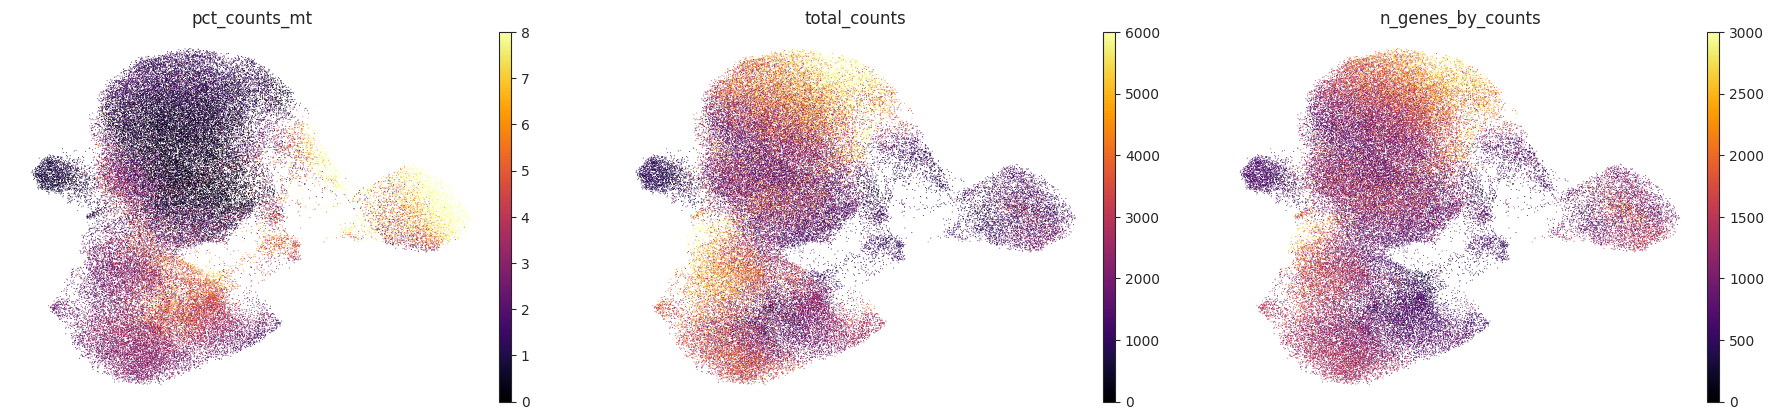

In [13]:
sc.pl.umap(
    adata,
    color=["pct_counts_mt", "total_counts", "n_genes_by_counts"],
    cmap="inferno",
    vmin=0,
    vmax=[8,6000,3000],
    sort_order=False,
    show=False,
    frameon=False
)

In [14]:
adata.obs["is_droplet"] = np.where(
      (adata.obs["total_counts"] < 5000)
    & (adata.obs["n_genes_by_counts"] < 3000)& (adata.obs["pct_counts_mt"] > 6),"droplet","normal")

In [ ]:
adata_filtered = adata[adata.obs["is_droplet"]!="droplet"]

In [ ]:
sc.pl.umap(
    adata_filtered,
    color=["pct_counts_mt", "total_counts", "n_genes_by_counts"],
    cmap="inferno",
    vmin=0,
    vmax=[8,6000,3000],
    sort_order=False,
    show=False,
    ,frameon=False
)

In [ ]:
adata_filtered.var["mito"] = adata_filtered.var_names.str.startswith("mt")
adata_filtered.var["ribo"] = adata_filtered.var_names.str.startswith("Rp")
adata_filtered.var["hb"] = adata_filtered.var_names.str.startswith("hb")
sc.pp.calculate_qc_metrics(
    adata_filtered,
    qc_vars=["mito", "ribo", "hb"],
    inplace=True,
    percent_top=[20],
    log1p=True,
)

In [ ]:
from typing import Optional

import numpy as np
import pandas as pd
from anndata import AnnData
from scipy.stats import median_abs_deviation


def is_outlier(adata: AnnData, metric_col: str, *, groupby: Optional[str] = None, n_mads: float = 5) -> pd.Series:
    """Detect outliers by median absolute deviation (MAD).

    Adapted from https://www.sc-best-practices.org/preprocessing_visualization/quality_control.html#motivation

    Parameters
    ----------
    adata
        AnnData object
    metric_col
        column in adata.obs to consider
    groupby
        grouping variable. If specified, outliers will be determined for each value of this grouping variable separately.
        E.g. `dataset`.
    n_mads
        label points that are outside of median +/- nmads * MAD.
    """

    def _is_outlier(df):
        """Check if metric value deviates from the median by more than n_mads MADs."""
        metric_values = df[metric_col]
        return np.abs(metric_values - np.median(metric_values)) > n_mads * median_abs_deviation(metric_values)

    if groupby is None:
        return _is_outlier(adata.obs)
    else:
        return adata.obs.groupby(groupby).apply(_is_outlier).droplevel(groupby).reindex(adata.obs_names)  # type: ignore

In [ ]:
adata_filtered.obs["is_outlier_counts"] = is_outlier(
    adata_filtered, "log1p_total_counts", n_mads=1.5, groupby="sample_id"
)
adata_filtered.obs["is_outlier_genes"] = is_outlier(
    adata_filtered, "log1p_n_genes_by_counts", n_mads=1.5, groupby="sample_id"
)
adata_filtered.obs["is_outlier_top_20"] = is_outlier(
    adata_filtered, "pct_counts_in_top_20_genes", n_mads=1.5, groupby="sample_id"
)
adata_filtered.obs["is_outlier_mito"] = is_outlier(
    adata_filtered, "pct_counts_mito", n_mads=3, groupby="sample_id"
)

adata_filtered.obs["is_outlier"] = (
    np.sum(
        adata_filtered.obs.loc[
            :,
            [
                "is_outlier_counts",
                "is_outlier_genes",
                "is_outlier_top_20",
                "is_outlier_mito",
            ],
        ],
        axis=1,
    )
    >= 2
)

In [ ]:
adata

In [ ]:
adata_filtered

In [ ]:
sc.pl.umap(
    adata_filtered,
    color=["pct_counts_mt", "total_counts", "n_genes_by_counts"],
    cmap="inferno",
    vmin=0,
    vmax=[8,6000,3000],
    sort_order=False,
    show=False,frameon=False
)

In [ ]:
adata = adata_filtered

In [ ]:
sc.pl.umap(adata, color=["leiden","sample_id"], frameon=False)

In [ ]:
sc.pl.umap(adata, color=["leiden","COND"],frameon=False, save = "umap_leiden_cond.png")

In [ ]:
sc.pl.umap(adata, color=["COND"], groups =["11mix","10mix"],frameon=False,save = "11mix_10mix_cond.png")

In [ ]:
sc.pl.umap(adata, color=["origin"],frameon=False,save = "umap_origin.png")

In [ ]:
sc.pl.umap(adata, color=["Mki67"], cmap="Reds",vmax="p99",frameon=False, save = "umap_cycling.png")

## SCCODA

In [ ]:
set(adata.obs.sample_id)

In [ ]:
cov_df = pd.DataFrame({"condiiton": ["10mix", "10mix", "10mix","10mix","11mix","11mix","11mix","11mix","GF","GF","GF"]}, index=['10mix-ICI1',
 '10mix-ICI2',
 '10mix1',
 '10mix2',
 '11mix-ICI1',
 '11mix-ICI2',
 '11mix1',
 '11mix2',
 'GF-ICI1-plus',
 'GF-ICI2-plus',
 'GF1'])
print(cov_df)

In [ ]:
adata.obs

In [ ]:
# Markers from publication doi: 10.1038/s41568-019-0235-4
#CD8+ T cell states in human cancer: insights from single-cell analysis
# Reference study: Zhang (CRC) Human 
naive_markers = ["Lef1","Sell","Ccr7","Tcf7","Cd27","Cd28","S1pr1"] # Naive-like
effector_memory_markers = ["Gzmk","Cxcr4","Cxcr3","Cd44"] #Predysfunctional
exhausted_markers = ["Havcr2","Pdcd1","Ifng","Itgae"] #  Dysfunctional #Layn, Cxcl13 not found
activated_effector_memory_marker  = ["Cx3cr1","Klrg1","Prf1","Tbx21","Eomes","S1pr1","S1pr5"] # Temra, #Cytotoxic #not found "Fcgr3a","Fgfbp2""Gzmh"

#* not described in table 1 
central_memory_markers = ["Gpr183","Ccr7","Sell","Il7r","Cd27","Cd28","Gzma","Ccl5","S1pr1","Gzma"] # not described in table 1 
tissue_resident_memory_markers = ["Cd6","Myadm","Capg","Rora","Nr4a1","Nr4a2","Nr4a3","Cd69","Itgae"] # not described in table 1  #not found "Cxcl1" ,"Xcl2"

#**Tumour type-specific T cell subsets that are not included in Table 1
intraepitheliel_lymphocytes_markers = ["Cd160","Klrc1","Klrc2","Ikzf2","Entpd1","Cd69","Itgae","Nr4a1","Nr4a2"] #IEL #"Kir2dl4","Timigd2"
mucosal_associated_invariant_markers = ["Zbtb16","Rora"] # MAIT # not found "Rorc"

In [ ]:
sc.pl.umap(adata, color=exhausted_markers,
    cmap="Reds",
    vmin=0,
    vmax="p99",
    sort_order=False,
    show=False,frameon=False,save = "umap_exhausted.png")

In [ ]:
sc.pl.umap(adata, color=effector_memory_markers,
    cmap="Reds",
    vmin=0,
    vmax="p99",
    sort_order=False,
    show=False,frameon=False,save = "umap_effector_memory.png")

In [ ]:
sc.pl.umap(adata, color=activated_effector_memory_marker,
    cmap="Reds",
    vmin=0,
    vmax="p99",
    sort_order=False,
    show=False,frameon=False,save = "umap_activated_effector_memory.png")

In [ ]:
sc.pl.umap(adata, color=central_memory_markers,
    cmap="Reds",
    vmin=0,
    vmax="p99",
    sort_order=False,
    show=False,frameon=False,save = "umap_central_memory.png")

In [ ]:
sc.pl.umap(adata, color=tissue_resident_memory_markers,
    cmap="Reds",
    vmin=0,
    vmax="p99",
    sort_order=False,
    show=False,frameon=False,save = "umap_tissue_resident_memory.png")

In [ ]:
sc.pl.umap(adata, color=intraepitheliel_lymphocytes_markers,
    cmap="Reds",
    vmin=0,
    vmax="p99",
    sort_order=False,
    show=False,frameon=False,save = "umap_intraepitheliel_lymphocytes.png")

In [ ]:
sc.pl.umap(adata, color=mucosal_associated_invariant_markers,
    cmap="Reds",
    vmin=0,
    vmax="p99",
    sort_order=False,
    show=False,frameon=False,save = "umap_mucosal_associated_invariant.png")

In [ ]:
sc.pl.umap(adata, color=["Icos","Itgae","Cd69","Cd44"],
    cmap="Reds",
    vmin=0,
    vmax="p99",
    sort_order=False,
    show=False,frameon=False)#,save = "umap_mucosal_associated_invariant.png")

In [ ]:
sc.pl.umap(adata, color=["Cxcr3"],
    cmap="Reds",
    vmin=0,
    vmax="p99",
    sort_order=False,
    show=False,frameon=False)#,save = "umap_mucosal_associated_invariant.png")

In [ ]:
sc.pl.umap(adata, color=["Ifng"],
    cmap="Reds",
    vmin=0,
    vmax="p99",
    sort_order=False,
    show=False,frameon=False)#,save = "umap_mucosal_associated_invariant.png")

In [ ]:
sc.pl.umap(adata, color="leiden_0.3",groups=["1"], frameon=False)

In [ ]:
sc.pl.umap(adata, color="leiden_0.3",groups=["2"], frameon=False)

In [ ]:
sc.pl.umap(adata, color="leiden_0.3",groups=["3"], frameon=False)

In [ ]:
sc.pp.normalize_total(adata, target_sum=1e4)

In [ ]:
adata.layers['log1p_norm'] = np.log1p(adata.X)

In [ ]:
adata.obs["ifng_positive"] = score_seeds(
    adata,
    {
        "ifng_positive": {
            "positive": [['Ifng']],
            "negative": [[""]],
        },
   },
    cutoff_sum_pos_marker_expression=0.5,
)

In [ ]:
adata.obs["cxcr3_positive"] = score_seeds(
    adata,
    {
        "cxcr3_positive": {
            "positive": [['Cxcr3']],
            "negative": [[""]],
        },
   },
    cutoff_sum_pos_marker_expression=0.5,
)

In [ ]:
adata.obs["icos_positive"] = score_seeds(
    adata,
    {
        "icos_positive": {
            "positive": [['Icos']],
            "negative": [[""]],
        },
   },
    cutoff_sum_pos_marker_expression=0.5,
)

In [ ]:
adata.obs["markers"] = score_seeds(
    adata,
    {
        "icos_positive": {
            "positive": [['Icos']],
            "negative": [[""]],
        },
        "cxcr3_positive": {
            "positive": [['Cxcr3']],
            "negative": [[""]],
        },
        "ifng_positive": {
            "positive": [['Ifng']],
            "negative": [[""]],
        },
        "cd69_positive": {
            "positive": [['Cd69']],
            "negative": [[""]],
        },
         "Cd44_positive": {
            "positive": [['Cd44']],
            "negative": [[""]],
        },
          "Itgae_positive": {
            "positive": [['Itgae']],
            "negative": [[""]],
        },
         "Havcr2_positive": {
            "positive": [['Havcr2']],
            "negative": [[""]],
        },
        "Pdcd1_positive": {
            "positive": [['Pdcd1']],
            "negative": [[""]],
        },
         "Gzmk_positive": {
            "positive": [['Gzmk']],
            "negative": [[""]],
        },
               "Gzma_positive": {
            "positive": [['Gzma']],
            "negative": [[""]],
        },
         "Gzmb_positive": {
            "positive": [['Gzmb']],
            "negative": [[""]],
        },
       
   },
    cutoff_sum_pos_marker_expression=0.2,
)

In [ ]:
adata.obs.markers.value_counts()

In [ ]:
sc.pl.umap(adata, color="markers",groups = ["Gzmk_positive","Gzma_positive","Gzmb_positive"], frameon=False)

In [ ]:
sc.pl.umap(adata, color="markers",groups = ["icos_positive"], frameon=False)

In [ ]:
sc.pl.umap(adata, color="markers",groups = ["cxcr3_positive"], frameon=False)

In [ ]:
sc.pl.umap(adata, color="markers",groups = ["Pdcd1_positive"], frameon=False)

In [ ]:
sc.pl.umap(adata, color="markers",groups = ["cd69_positive"], frameon=False)

In [ ]:
sc.pl.umap(adata, color="markers",groups = ["Itgae_positive"], frameon=False)

In [ ]:
adata.obs.ifng_positive.value_counts()

In [ ]:
adata_ifng = adata[adata.obs["ifng_positive"] == "ifng_positive"]

In [ ]:
adata_cxcr3 = adata[adata.obs["cxcr3_positive"] == "cxcr3_positive"]

In [ ]:
adata_icos = adata[adata.obs["icos_positive"] == "icos_positive"]

In [ ]:
adata_icos.obs.sample_id.value_counts()

In [ ]:
adata_ifng.obs.sample_id.value_counts()

In [ ]:
adata_ifng.obs.COND.value_counts()

In [ ]:
sc.pl.umap(adata_ifng, color="COND",groups="10mix", frameon=False)

In [ ]:
adata_cxcr3.obs.sample_id.value_counts()

In [ ]:
adata_cxcr3.obs.COND.value_counts()

In [ ]:
sc.pl.umap(adata_cxcr3, color="COND", groups=["11mix"], frameon=False)

In [ ]:
## 11mix and 11mix ICI1

In [ ]:
adata_11mix1 = sc.read_h5ad("/data/projects/2021/MicrobialMetabolites/single-cell-sorted-cd8/results/results_by_sample/scar_by_sample/11mix1_adata_filtered_denoised_adata.h5ad")

In [ ]:
adata_11mix_ICI1 = sc.read_h5ad("/data/projects/2021/MicrobialMetabolites/single-cell-sorted-cd8/results/results_by_sample/scar_by_sample/11mix-ICI1_adata_filtered_denoised_adata.h5ad")

In [ ]:
adata_11mix1

In [ ]:
adata_11mix_ICI1

In [ ]:
### adata_11mix

In [ ]:
adata_11mix1.var_names_make_unique() 

In [ ]:
sc.pp.filter_cells(adata_11mix1, min_genes=200)
sc.pp.filter_genes(adata_11mix1, min_cells=3)

In [ ]:
adata_11mix1.var["mt"] = adata_11mix1.var.gene_name.str.startswith("mt-")
sc.pp.calculate_qc_metrics(
    adata_11mix, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

In [ ]:
sc.pl.violin(
    adata_11mix1,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

In [ ]:
sc.pl.scatter(adata_11mix1, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata_11mix1, x="total_counts", y="n_genes_by_counts")

In [ ]:
adata_11mix1 = adata_11mix1[adata_11mix1.obs.n_genes_by_counts < 2500, :]
adata_11mix1 = adata_11mix1[adata_11mix1.obs.pct_counts_mt < 5, :].copy()

In [ ]:
sc.pp.normalize_total(adata_11mix1, target_sum=1e4)

In [ ]:
adata_11mix1.layers['log1p_norm'] = np.log1p(adata_11mix1.X)

In [ ]:
sc.pl.highest_expr_genes(adata_11mix1, n_top=20, gene_symbols = "gene_name", log = False)

In [ ]:
sc.pp.highly_variable_genes(adata_11mix1,  min_mean=0.0125, max_mean=3, min_disp=0.5, layer ="log1p_norm")

In [ ]:
sc.pl.highly_variable_genes(adata_11mix1)

In [ ]:
adata_11mix1.raw = adata_11mix1

In [ ]:
adata_11mix1 = adata_11mix1[:, adata_11mix1.var.highly_variable]

In [ ]:
sc.pp.regress_out(adata_11mix1, ["total_counts", "pct_counts_mt"])

In [ ]:
sc.pp.scale(adata_11mix1, max_value=10)

In [ ]:
sc.tl.pca(adata_11mix1, svd_solver="arpack")

In [ ]:
sc.pl.pca_variance_ratio(adata_11mix1, log=True)

In [ ]:
sc.pp.neighbors(adata_11mix1, n_neighbors=10, n_pcs=40)

In [ ]:
sc.tl.leiden(
    adata_11mix1,
    resolution=0.5,
    random_state=0,
    n_iterations=2,
    directed=False,
)

In [ ]:
sc.tl.paga(adata_11mix1)
sc.pl.paga(adata_11mix1, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata_11mix1, init_pos='paga')

In [ ]:
sc.tl.umap(adata_11mix1)

In [ ]:
adata_11mix1

In [ ]:
sc.pl.umap(adata_11mix1, color=["leiden"])

In [ ]:
sc.pl.umap(adata_11mix1, color=["Ifng"], gene_symbols="gene_name", vmax="p99", cmap ="Reds")

In [ ]:
# %%
from typing import Dict

import numpy as np
import pandas as pd
from anndata import AnnData


def score_seeds(
    adata: AnnData,
    seed_marker_genes: Dict[str, Dict[str, list]],
    layer: str = "log1p_norm",
    cutoff_sum_pos_marker_expression: float = 0.1,
    cutoff_sum_neg_marker_expression: float = 0,
) -> pd.Series:
    """Label seed cell types based on input pos/neg marker gene expression"""
    
    def _score_ct(adata, seed_marker_genes, layer, cutoff_sum_pos_marker_expression):
        tmp_df = pd.DataFrame(index=adata.obs_names)
        
        for cell_type, markers in seed_marker_genes.items():
            positive_conditions = []
            negative_conditions = []
            
            for positive_markers_list in markers['positive']:
                positive_condition = np.ravel(adata[:, adata.var_names.isin(positive_markers_list)].layers[layer].sum(1)) > cutoff_sum_pos_marker_expression
                positive_conditions.append(positive_condition)
            
            for negative_markers_list in markers['negative']:
                negative_condition = ~(np.ravel(adata[:, adata.var_names.isin(negative_markers_list)].layers[layer].sum(1)) > cutoff_sum_neg_marker_expression)
                negative_conditions.append(negative_condition)
            
            combined_positive_condition = np.all(positive_conditions, axis=0)
            combined_negative_condition = np.all(negative_conditions, axis=0)
            
            condition = combined_positive_condition & combined_negative_condition
            tmp_df[f"tmp_{cell_type}"] = np.where(condition, cell_type, "unknown")
        
        return tmp_df

    
    def _combine_ct(row):
        for ct in seed_ct:
            if row[ct] != 'unknown':
                return row[ct]
        return 'unknown'

    seed_df = _score_ct(adata, seed_marker_genes, layer, cutoff_sum_pos_marker_expression)
    seed_ct = [f"tmp_{ct}" for ct in seed_marker_genes.keys()]
    
    return seed_df.apply(_combine_ct, axis=1)

In [ ]:
adata_11mix1.obs["ifng_positive"] = score_seeds(
    adata_11mix1,
    {
        "ifng_positive": {
            "positive": [['Ifng']],
            "negative": [[""]],
        },
   },
    cutoff_sum_pos_marker_expression=0.5,
)

In [ ]:
adata_11mix1.obs.ifng_positive.value_counts()

In [ ]:
adata_11mix1

In [ ]:
0.12

In [ ]:
import besca as bc


In [ ]:
adata_11mix_ICI1.var_names_make_unique() 

In [ ]:
sc.pp.filter_cells(adata_11mix_ICI1, min_genes=200)
sc.pp.filter_genes(adata_11mix_ICI1, min_cells=3)

In [ ]:
adata_11mix_ICI1.var["mt"] = adata_11mix_ICI1.var.gene_name.str.startswith("mt-")
sc.pp.calculate_qc_metrics(
    adata_11mix, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

In [ ]:
sc.pl.violin(
    adata_11mix_ICI1,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

In [ ]:
sc.pl.scatter(adata_11mix_ICI1, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata_11mix_ICI1, x="total_counts", y="n_genes_by_counts")

In [ ]:
adata_11mix_ICI1 = adata_11mix_ICI1[adata_11mix_ICI1.obs.n_genes_by_counts < 2500, :]
adata_11mix_ICI1 = adata_11mix_ICI1[adata_11mix_ICI1.obs.pct_counts_mt < 5, :].copy()

In [ ]:
sc.pp.normalize_total(adata_11mix_ICI1, target_sum=1e4)

In [ ]:
adata_11mix_ICI1.layers['log1p_norm'] = np.log1p(adata_11mix_ICI1.X)

In [ ]:
sc.pl.highest_expr_genes(adata_11mix_ICI1, n_top=20, gene_symbols = "gene_name", log = False)

In [ ]:
sc.pp.highly_variable_genes(adata_11mix_ICI1,  min_mean=0.0125, max_mean=3, min_disp=0.5, layer ="log1p_norm")

In [ ]:
sc.pl.highly_variable_genes(adata_11mix_ICI1)

In [ ]:
adata_11mix_ICI1.raw = adata_11mix_ICI1

In [ ]:
adata_11mix_ICI1 = adata_11mix_ICI1[:, adata_11mix_ICI1.var.highly_variable]

In [ ]:
sc.pp.regress_out(adata_11mix_ICI1, ["total_counts", "pct_counts_mt"])

In [ ]:
sc.pp.scale(adata_11mix_ICI1, max_value=10)

In [ ]:
sc.tl.pca(adata_11mix_ICI1, svd_solver="arpack")

In [ ]:
sc.pl.pca_variance_ratio(adata_11mix_ICI1, log=True)

In [ ]:
sc.pp.neighbors(adata_11mix_ICI1, n_neighbors=10, n_pcs=40)

In [ ]:
sc.tl.leiden(
    adata_11mix_ICI1,
    resolution=0.5,
    random_state=0,
    n_iterations=2,
    directed=False,
)

In [ ]:
sc.tl.paga(adata_11mix_ICI1)
sc.pl.paga(adata_11mix_ICI1, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata_11mix_ICI1, init_pos='paga')

In [ ]:
sc.tl.umap(adata_11mix_ICI1)

In [ ]:
adata_11mix_ICI1

In [ ]:
sc.pl.umap(adata_11mix_ICI1, color=["leiden"])

In [ ]:
sc.pl.umap(adata_11mix_ICI1, color=["Ifng"], gene_symbols="gene_name", vmax="p99", cmap ="Reds")

In [ ]:
# %%
from typing import Dict

import numpy as np
import pandas as pd
from anndata import AnnData


def score_seeds(
    adata: AnnData,
    seed_marker_genes: Dict[str, Dict[str, list]],
    layer: str = "log1p_norm",
    cutoff_sum_pos_marker_expression: float = 0.1,
    cutoff_sum_neg_marker_expression: float = 0,
) -> pd.Series:
    """Label seed cell types based on input pos/neg marker gene expression"""
    
    def _score_ct(adata, seed_marker_genes, layer, cutoff_sum_pos_marker_expression):
        tmp_df = pd.DataFrame(index=adata.obs_names)
        
        for cell_type, markers in seed_marker_genes.items():
            positive_conditions = []
            negative_conditions = []
            
            for positive_markers_list in markers['positive']:
                positive_condition = np.ravel(adata[:, adata.var_names.isin(positive_markers_list)].layers[layer].sum(1)) > cutoff_sum_pos_marker_expression
                positive_conditions.append(positive_condition)
            
            for negative_markers_list in markers['negative']:
                negative_condition = ~(np.ravel(adata[:, adata.var_names.isin(negative_markers_list)].layers[layer].sum(1)) > cutoff_sum_neg_marker_expression)
                negative_conditions.append(negative_condition)
            
            combined_positive_condition = np.all(positive_conditions, axis=0)
            combined_negative_condition = np.all(negative_conditions, axis=0)
            
            condition = combined_positive_condition & combined_negative_condition
            tmp_df[f"tmp_{cell_type}"] = np.where(condition, cell_type, "unknown")
        
        return tmp_df

    
    def _combine_ct(row):
        for ct in seed_ct:
            if row[ct] != 'unknown':
                return row[ct]
        return 'unknown'

    seed_df = _score_ct(adata, seed_marker_genes, layer, cutoff_sum_pos_marker_expression)
    seed_ct = [f"tmp_{ct}" for ct in seed_marker_genes.keys()]
    
    return seed_df.apply(_combine_ct, axis=1)

In [ ]:
adata_11mix_ICI1.var.set_index("gene_name", inplace=True)

In [ ]:
adata_11mix_ICI1.var["gene_name"] = adata_11mix_ICI1.var.index

In [ ]:
adata_11mix_ICI1.obs["ifng_positive"] = score_seeds(
    adata_11mix_ICI1,
    {
        "ifng_positive": {
            "positive": [['Ifng']],
            "negative": [[""]],
        },
   },
    cutoff_sum_pos_marker_expression=0.5,
)

In [ ]:
adata_11mix_ICI1.obs.ifng_positive.value_counts()

In [ ]:
adata_11mix_ICI1

In [ ]:
0.28